In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from operator import index
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from fastai.tabular.all import df_shrink
from google.colab import data_table
from google.colab import files
from sklearn import metrics
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import keras
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

testing = '/content/drive/MyDrive/Senior Database Files/KDDTest+.csv'
training = '/content/drive/MyDrive/Senior Database Files/KDDTrain+.csv'

train = pd.read_csv(training, encoding='utf-8')
test = pd.read_csv(testing, encoding='utf-8')

train = df_shrink(train, skip=[], obj2cat=True, int2uint=True)
test = df_shrink(test, skip=[], obj2cat=True, int2uint=True)

feature_type_map = {f: (train.dtypes.loc[f], test.dtypes.loc[f]) for f in train.columns}

len(train['class'].cat.categories), len(test['class'].cat.categories)

len(train.service.cat.categories), len(test.service.cat.categories)

def train_test_category_union(feature):
  tcl = len(train[feature].cat.categories)
  tcll = len(test[feature].cat.categories)
  feature_cat_union = train[feature].cat.categories.union(test[feature].cat.categories)
  train[feature] = train[feature].cat.set_categories(feature_cat_union)
  test[feature] = test[feature].cat.set_categories(feature_cat_union)

cat = list(train.select_dtypes(include='category').columns.values)

for f in cat:
  train_test_category_union(f)

le = LabelEncoder()
train['classification'] = le.fit_transform(train['class'])
test['classification'] = le.fit_transform(test['class'])
train.drop('class', axis=1, inplace=True)
test.drop('class', axis=1, inplace=True)
train['protocol_type'] = le.fit_transform(train['protocol_type'])
test['protocol_type'] = le.fit_transform(test['protocol_type'])
train['service'] = le.fit_transform(train['service'])
test['service'] = le.fit_transform(test['service'])
train['flag'] = le.fit_transform(train['flag'])
test['flag'] = le.fit_transform(test['flag'])
train['land'] = le.fit_transform(train['land'])
test['land'] = le.fit_transform(test['land'])
train['logged_in'] = le.fit_transform(train['logged_in'])
test['logged_in'] = le.fit_transform(test['logged_in'])
train['is_host_login'] = le.fit_transform(train['is_host_login'])
test['is_host_login'] = le.fit_transform(test['is_host_login'])
train['is_guest_login'] = le.fit_transform(train['is_guest_login'])
test['is_guest_login'] = le.fit_transform(test['is_guest_login'])

class_data_train = train['classification']

train_index = train.columns
mutual_info = mutual_info_classif(train, class_data_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(train, class_data_train)
new_col = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'classification']
train = train[new_col]
test = test[new_col]

#one hot encoding on all nominal categories except class
test = pd.get_dummies(test, columns=['protocol_type', 'service', 'flag', 'logged_in'])
train = pd.get_dummies(train, columns=['protocol_type', 'service', 'flag', 'logged_in'])

#robust scaling for normalization step
target_train = train['classification'].copy()
target_test = test['classification'].copy()
robust_scaler1 = RobustScaler()
robust_scaler2 = RobustScaler()
train.drop('classification', axis=1, inplace=True)
test.drop('classification', axis=1, inplace=True)
data1 = test.values[:, :]
data2 = train.values[:, :]
data1 = robust_scaler1.fit_transform(data1)
data2 = robust_scaler2.fit_transform(data2)
#converting array back to dataframe
test = pd.DataFrame(data1)
train = pd.DataFrame(data2)
#Preprocessing ends here
#print(target_test)

In [5]:
num_components = 44
pca = PCA(n_components=num_components)
pca.fit(train)
train_pca = pca.transform(train)
train_pca = pd.DataFrame(train_pca)
pca.fit(test)
test_pca = pca.transform(test)
test_pca = pd.DataFrame(test_pca)
estimate = 17
contam = 0.4309778452019331906885923
samples = 89
state = 6780
detection_model = IsolationForest(n_estimators=estimate, contamination=contam, random_state=state, max_samples=samples)
detection_model.fit(train_pca)
y_test_pred = detection_model.predict(test_pca)

for i in range(len(y_test_pred)):
  if y_test_pred[i] == -1:
    y_test_pred[i] = 0
  else:
    y_test_pred[i] = 1

print("accuracy:", accuracy_score(target_test, y_test_pred))
print("precision:", metrics.precision_score(target_test, y_test_pred))
print("recall:", metrics.recall_score(target_test, y_test_pred))
print("f1:", metrics.f1_score(target_test, y_test_pred))
print("auc:", metrics.roc_auc_score(target_test, y_test_pred))

accuracy: 0.9105305180979418
precision: 0.9260243632336655
recall: 0.8610853671094635
f1: 0.8923750066698682
auc: 0.9045160335118735


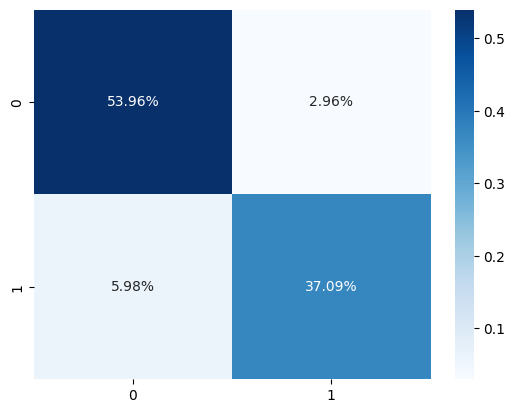

In [ ]:
confusion_matrix = metrics.confusion_matrix(target_test, y_test_pred)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
#cm_display.plot()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

ValueError: x and y must be the same size

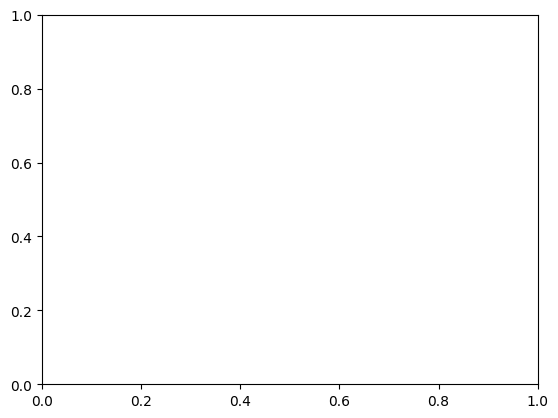

In [ ]:
#plt.figure(figsize=(50,50))
plt.figure()
#plt.ylim(0, 50)
#plt.xlim(0,1000)
plt.scatter(test.iloc[y_test_pred==1].values, test.iloc[y_test_pred==0].values, c='blue', label='Normal')
plt.scatter(test.iloc[y_test_pred==1,0].values, test.iloc[y_test_pred==1,1].values, c='red', label='Anomaly')
plt.legend()
plt.show()

In [ ]:
detection_model.save_model('isolation_forest_model.pkl')

AttributeError: 'IsolationForest' object has no attribute 'save_model'

In [ ]:
joblib.dump(detection_model, 'isolation_forest_model.pkl')
files.download('isolation_forest_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

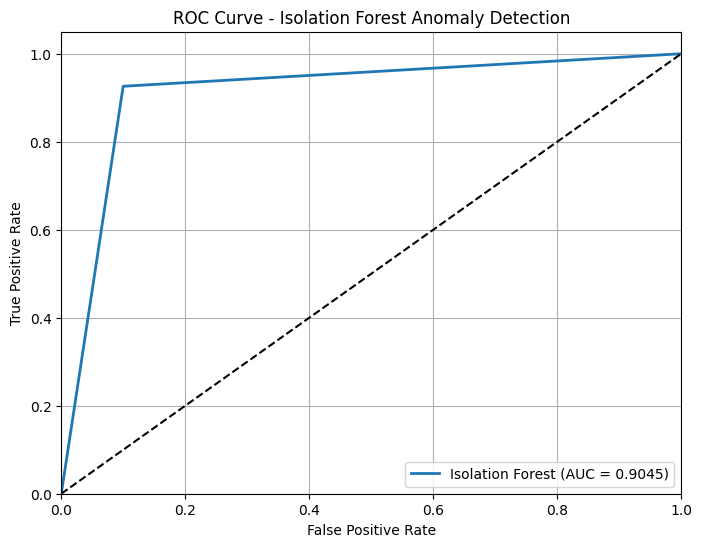

In [ ]:
from sklearn.metrics import roc_curve

# Plot ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

tpr, fpr, thresholds = roc_curve(y_test_pred, target_test)
plt.figure(figsize=(8, 6))
plt.plot(tpr, fpr, linewidth=2, label=f'Isolation Forest (AUC = {roc_auc_score(target_test, y_test_pred):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest Anomaly Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 20 most correlated features (by average correlation):
['flag_SF', 'serror_rate', 'srv_serror_rate', 'flag_S0', 'logged_in_no', 'logged_in_yes', 'protocol_udp', 'count', 'service_http_8001', 'protocol_icmp', 'rerror_rate', 'service_remote_job', 'protocol_tcp', 'srv_count', 'flag_REJ', 'service_ecr_i', 'service_finger', 'service_exec', 'service_ssh', 'flag_RSTR']


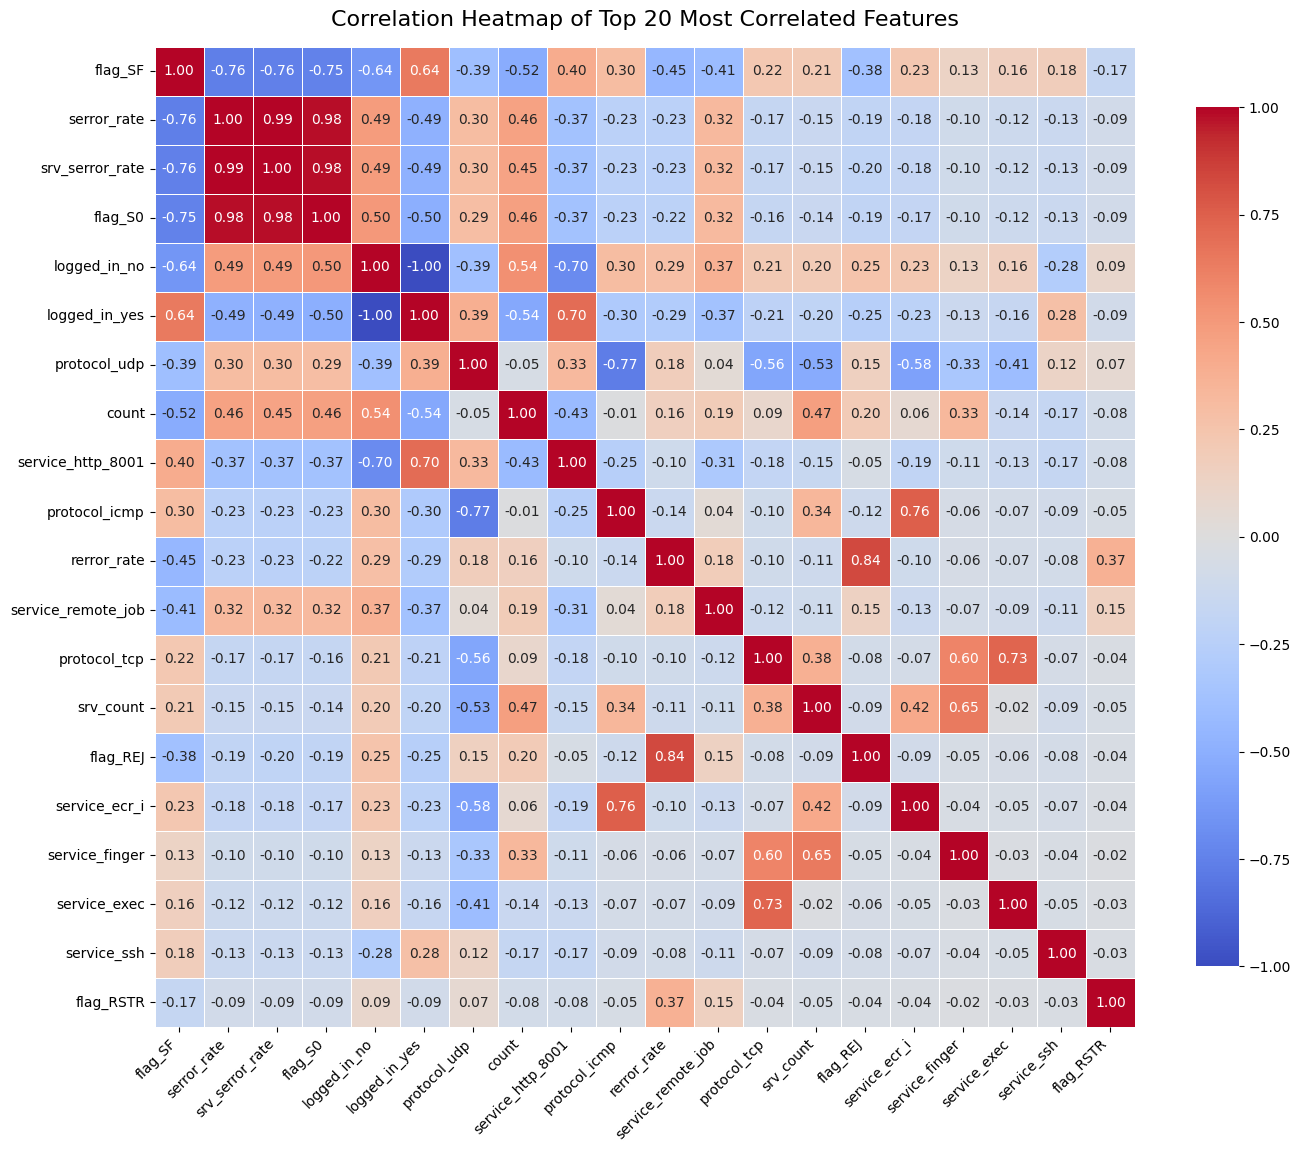

In [ ]:
# Compute full correlation matrix of the current train dataset
corr_matrix = train.corr()

# Compute average absolute correlation of each feature with all others
avg_corr = corr_matrix.abs().mean().sort_values(ascending=False)

# Select top 20 features with the highest average correlation
top20_features = avg_corr.head(20).index.tolist()

print(f"Top 20 most correlated features (by average correlation):\n{top20_features}")

# Compute correlation matrix for those 20 features
corr_top20 = train[top20_features].corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_top20,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Top 20 Most Correlated Features", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
